# Text Summarization using machine learning techniques

## Exploratory Data Analysis

### Importing the libraries

For the very first time, we need to install the following libraries

In [88]:
!pip install wordcloud
!pip install gensim
!pip install pyLDAvis

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import os

import re, string
import nltk
nltk.download('stopwords')
nltk.download('punkt')
stopword = nltk.corpus.stopwords.words('english')

# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA

import warnings
warnings.simplefilter("ignore", DeprecationWarning)


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [87]:
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis

We ned to install the Wordcloud library just for the very first time, it will be used later on this analysis 

### Loading the dataset
First step, load the whole dataset hosted locally

In [6]:
# Run only when new datafiles have been stored in GS
%%bash
gsutil cp gs://mlend_bucket/data/news_summary/news_summary_more.csv ../data/

Copying gs://mlend_bucket/data/news_summary/news_summary_more.csv...
- [1 files][ 39.5 MiB/ 39.5 MiB]                                                
Operation completed over 1 objects/39.5 MiB.                                     


In [2]:
summary = pd.read_csv('../data/news_summary.csv', encoding='iso-8859-1')
#raw = pd.read_csv('../data/news_summary_more.csv', encoding='iso-8859-1')
summary.head(5)

,author,date,headlines,read_more,text,ctext
0,Chhavi Tyagi,"03 Aug 2017,Thursday",Daman & Diu revokes mandatory Rakshabandhan in...,http://www.hindustantimes.com/india-news/raksh...,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Daisy Mowke,"03 Aug 2017,Thursday",Malaika slams user who trolled her for 'divorc...,http://www.hindustantimes.com/bollywood/malaik...,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,Arshiya Chopra,"03 Aug 2017,Thursday",'Virgin' now corrected to 'Unmarried' in IGIMS...,http://www.hindustantimes.com/patna/bihar-igim...,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Sumedha Sehra,"03 Aug 2017,Thursday",Aaj aapne pakad liya: LeT man Dujana before be...,http://indiatoday.intoday.in/story/abu-dujana-...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Aarushi Maheshwari,"03 Aug 2017,Thursday",Hotel staff to get training to spot signs of s...,http://indiatoday.intoday.in/story/sex-traffic...,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [3]:
print(summary['headlines'][0],'\n',summary['text'][0],'\n',summary['ctext'][0])

Daman & Diu revokes mandatory Rakshabandhan in offices order 
 The Administration of Union Territory Daman and Diu has revoked its order that made it compulsory for women to tie rakhis to their male colleagues on the occasion of Rakshabandhan on August 7. The administration was forced to withdraw the decision within 24 hours of issuing the circular after it received flak from employees and was slammed on social media. 
 The Daman and Diu administration on Wednesday withdrew a circular that asked women staff to tie rakhis on male colleagues after the order triggered a backlash from employees and was ripped apart on social media.The union territory?s administration was forced to retreat within 24 hours of issuing the circular that made it compulsory for its staff to celebrate Rakshabandhan at workplace.?It has been decided to celebrate the festival of Rakshabandhan on August 7. In this connection, all offices/ departments shall remain open and celebrate the festival collectively at a sui

In [4]:
# Count the number of examples
print('Dataset examples: ', len(summary))
summary.describe()

Dataset examples:  4514


,author,date,headlines,read_more,text,ctext
count,4514,4514,4514,4514,4514,4396
unique,45,240,4514,4461,4514,4341
top,Chhavi Tyagi,"19 Jul 2017,Wednesday",Which Indian cities were worst hit by WannaCry...,http://indiatoday.intoday.in/story/assembly-el...,India has signed the OECD multilateral convent...,AAJ TAK LIVE TV WITH LIVE ELECTION RESULTS I c...
freq,559,76,1,13,1,13


When we see some examples, our variable candidate for 'Summary' would be text or perhaps a shorter one, 'Headlines'. I choose the longer one. And the variable ctext as the source text or complete text.
Then, we can observe that there are some rows with a null value in the variable ctext. So our first step would be to drop those rows and duplicate ones. 

In [5]:
summary.drop_duplicates(subset=["ctext"],inplace=True)
summary.dropna(inplace=True)
summary.reset_index(drop=True,inplace=True)
summary.describe()

,author,date,headlines,read_more,text,ctext
count,4341,4341,4341,4341,4341,4341
unique,45,240,4341,4341,4341,4341
top,Chhavi Tyagi,"19 Jul 2017,Wednesday",Which Indian cities were worst hit by WannaCry...,http://indiatoday.intoday.in/story/punjab-cm-p...,India has signed the OECD multilateral convent...,The theme for this year?s International Women?...
freq,537,76,1,1,1,1


Lets create a new dataframe with the variables we are interested in analyzing.

In [6]:
# we are using the text variable as the summary and the ctext as the source text
dataset = summary[['text','ctext']].copy()
dataset.columns = ['summary','text']
dataset.head(5)

,summary,text
0,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [ ]:
# Remove the special character like \n, \t,..


### Feature Engineering
The dataset contains only the two columns of interest - summary and text. In this section we will create some some additional features using these variables. Following list explains different ideas for creating new features.

In [7]:
#Define some global variables for text processing
punc = string.punctuation

#### Statistical Count Features from headline text
- Word Count - Total number of words in the headline
- Character Count - Total number of characters in the headline excluding spaces
- Word Density - Average length of the words used in the headline
- Punctuation Count - Total number of punctuations used in the headline
- ¿Upper-Case to Lower-Case Words ratio - ratio of upper case words used and lower case words used in the text?
- Stopwords Count - Total number of common stopwords in the text

In [8]:
dataset['sum_word_count'] = dataset['summary'].apply(lambda x : len(x.split()))
dataset['text_word_count'] = dataset['text'].apply(lambda x : len(x.split()))
dataset['sum_char_count'] = dataset['summary'].apply(lambda x : len(x.replace(" ","")))
dataset['text_char_count'] = dataset['text'].apply(lambda x : len(x.replace(" ","")))
dataset['sum_word_density'] = dataset['sum_word_count'] / (dataset['sum_char_count'] + 1)
dataset['text_word_density'] = dataset['text_word_count'] / (dataset['text_char_count'] + 1)

dataset['sum_punc_count'] = dataset['summary'].apply(lambda x : len([a for a in x if a in punc]))
dataset['text_punc_count'] = dataset['text'].apply(lambda x : len([a for a in x if a in punc]))

# Stopwords count######

print(dataset[['sum_word_count', 'sum_char_count', 'sum_word_density', 'sum_punc_count']].head(5))
print(dataset[['text_word_count', 'text_char_count', 'text_word_density', 'text_punc_count']].head(5))

   sum_word_count  sum_char_count  sum_word_density  sum_punc_count
0              60             299          0.200000               2
1              60             302          0.198020              21
2              60             339          0.176471              12
3              60             309          0.193548              23
4              60             307          0.194805               8
   text_word_count  text_char_count  text_word_density  text_punc_count
0              364             1950           0.186571               55
1              396             1981           0.199798               84
2              335             1780           0.188097               53
3              404             1981           0.203835               87
4              526             2724           0.193028               62


In [9]:
dataset[['sum_word_count', 'sum_char_count', 'sum_word_density', 'sum_punc_count']].describe()

,sum_word_count,sum_char_count,sum_word_density,sum_punc_count
count,4341.000000,4341.000000,4341.000000,4341.000000
mean,58.297858,297.426860,0.196331,9.969132
std,2.304367,23.049156,0.014742,4.211293
min,44.000000,227.000000,0.152738,2.000000
25%,57.000000,282.000000,0.185759,7.000000
50%,59.000000,298.000000,0.195440,9.000000
75%,60.000000,314.000000,0.205674,12.000000
max,62.000000,346.000000,0.258772,38.000000


Now, for a better understansing we will plot some figures

In [15]:
# Ww declare a new dataframe for plotting porpouses
data=dataset
labels_dict={'sum_word_count': 'Word Count of Summaries','text_word_count': 'Word Count of Texts',
             'sum_char_count': 'Char Count of Summaries','text_char_count': 'Char Count of Texts',
             'sum_word_density': 'Word Density of Summaries','text_word_density': 'Word Density of Texts',
             'sum_punc_count': 'Punctuation Count of Summaries','text_punc_count': 'Punctuation Count of Texts'}
# The next variable define which variable will be plotted in every position on the figure
# So, we can modify the draws easily
#plot_vars=np.array([['sum_word_count','text_word_count'],['sum_char_count','text_char_count'],
#                    ['sum_word_density','text_word_density'],['sum_punc_count','text_punc_count']])

plot_vars=np.array([['sum_word_count','sum_char_count','sum_word_density','sum_punc_count'],
                    ['text_word_count','text_char_count','text_word_density','text_punc_count']])

print(plot_vars.shape)


(2, 4)


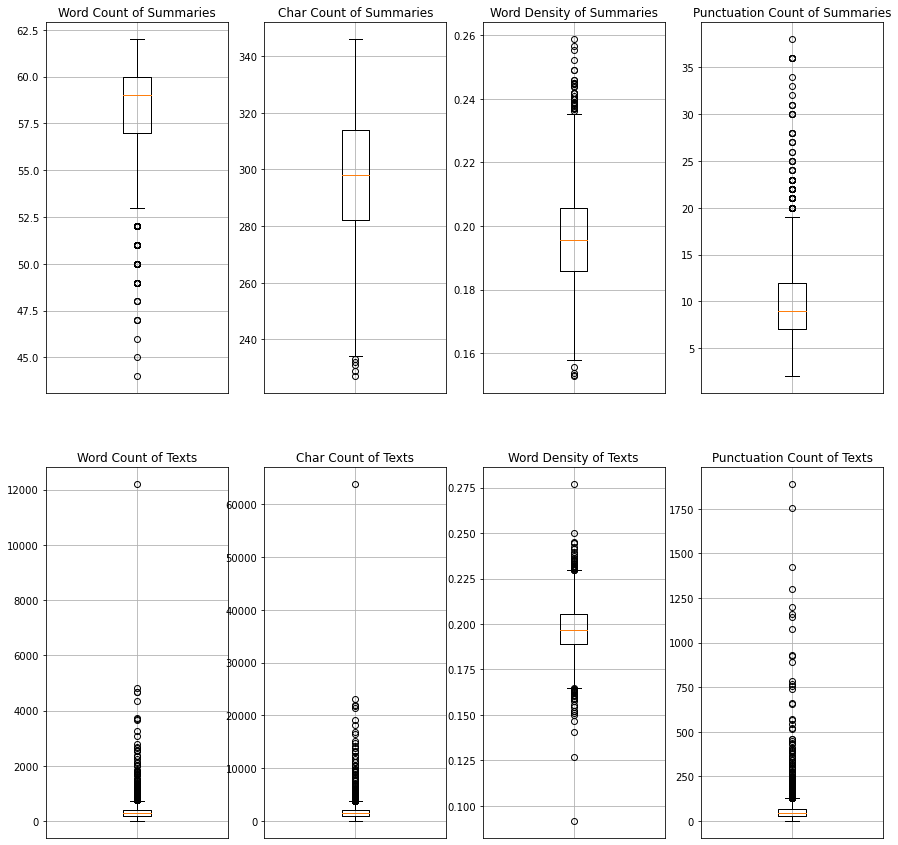

In [16]:
# Boxplots for appicant featrures
f, axes = plt.subplots(2, 4, sharey=False, figsize=(15,15))
#fig1, ax1 = plt.subplots()
for i in range(plot_vars.shape[0]):
    for j in range(plot_vars.shape[1]):
        if plot_vars[i,j]!=None:
            axes[i,j].set_title(labels_dict[plot_vars[i,j]])
            axes[i,j].grid(True)
            axes[i,j].tick_params(
                axis='x',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                labelbottom=False)
            axes[i,j].boxplot(data[plot_vars[i,j]])
        else:
            axes[i,j].set_visible(False)

plt.show()

There are many outliers for the calculated features on the text data. We can see some rows with a very large text. 
But for the summary variable the distribution 

(4, 2)


NameError: name 'values' is not defined

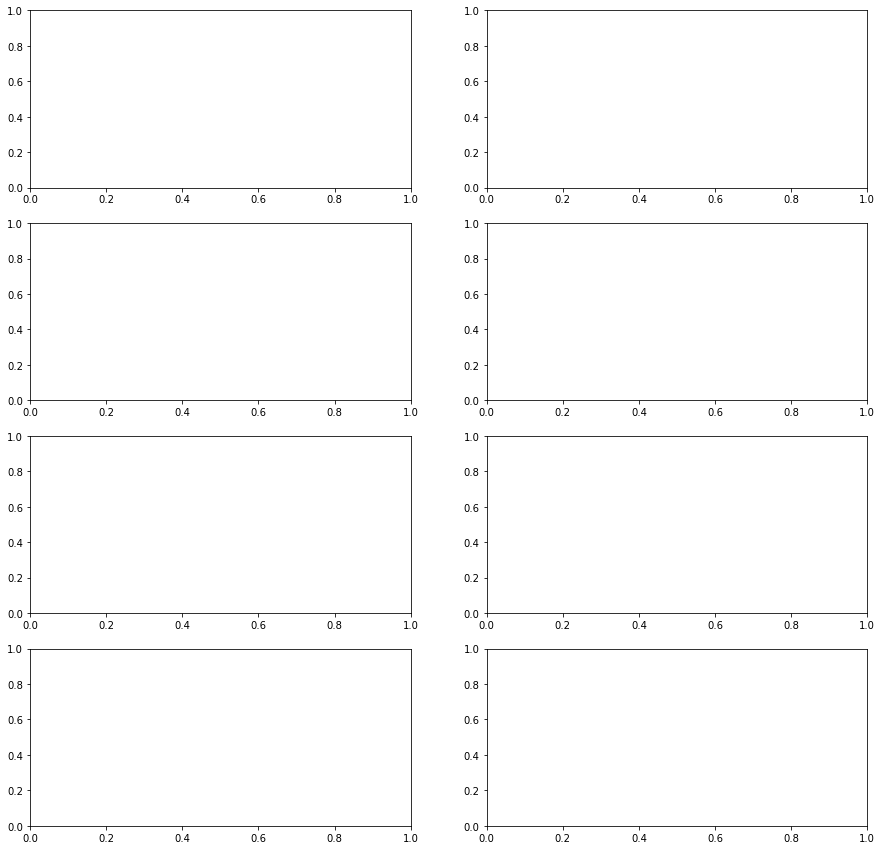

In [15]:
# Plot multiple Boxplots for the featrures
#Get the Cover Type values sorted
#We are defining an 3 x 4 matrix to help us plotting features
data=dataset

plot_vars=np.array([['sum_word_count','text_word_count'],['sum_char_count','text_char_count'],
                    ['sum_word_density','text_word_density'],['sum_punc_count','text_punc_count']])
print(plot_vars.shape)

f, axes = plt.subplots(4, 2, sharey=False, figsize=(15,15))
#fig1, ax1 = plt.subplots()
for i in range(plot_vars.shape[0]):
    for j in range(plot_vars.shape[1]):
        if plot_vars[i,j]!=None:
            for k in values:
                axes[i,j].hist(data[plot_vars[i,j]],alpha=0.7,histtype='bar',bins=30,label=str(k))
                
            axes[i,j].set_xlabel(plot_vars[i,j],labelpad=10,fontsize=10)
            if j==0:
                axes[i,j].set_ylabel('Count')
                axes[i,j].legend()
        else:
            axes[i,j].set_visible(False)

plt.show()

Now, lets explore the histograms (What is a hist) of the valculated variables, to get a better intuition about the texts we are goind to deal with.

In [17]:
# import the seaborn library, it is a powerful library for plotting and commonly used with matplotlib
import seaborn as sns
sns.set_style("white")


(0.0, 500.0)

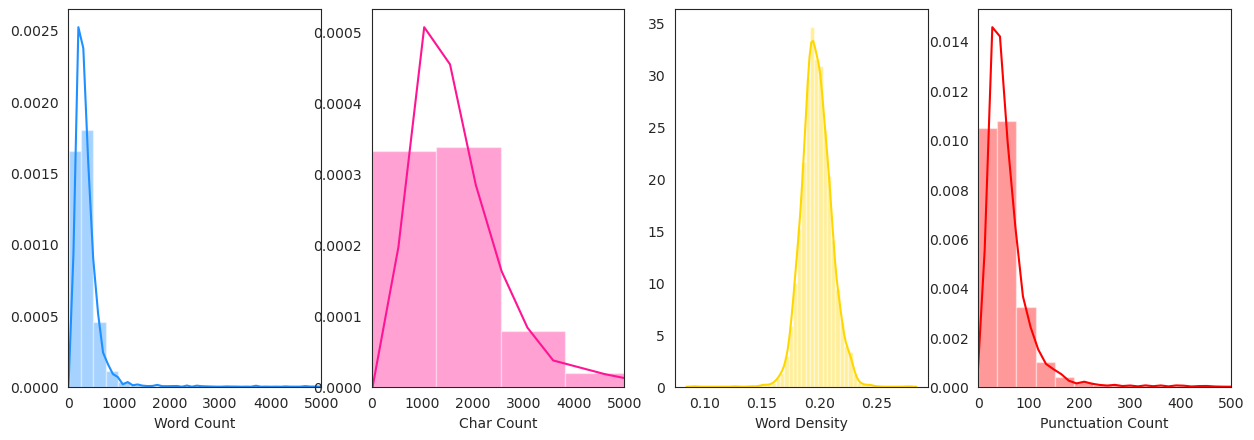

In [25]:
# Plot
kwargs = dict(hist_kws={'alpha':.7}, kde_kws={'linewidth':2})

# plot
fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharey=False, dpi=100)
sns.distplot(dataset['text_word_count'] , color="dodgerblue", ax=axes[0], axlabel='Word Count')
axes[0].set_xlim(left=0, right=5000)
sns.distplot(dataset['text_char_count'] , color="deeppink", ax=axes[1], axlabel='Char Count')
axes[1].set_xlim(left=0, right=5000)
sns.distplot(dataset['text_word_density'] , color="gold", ax=axes[2], axlabel='Word Density')
sns.distplot(dataset['text_punc_count'] , color="red", ax=axes[3], axlabel='Punctuation Count')
axes[3].set_xlim(left=0, right=500)
#plt.xlim(50,75);
#plt.legend()

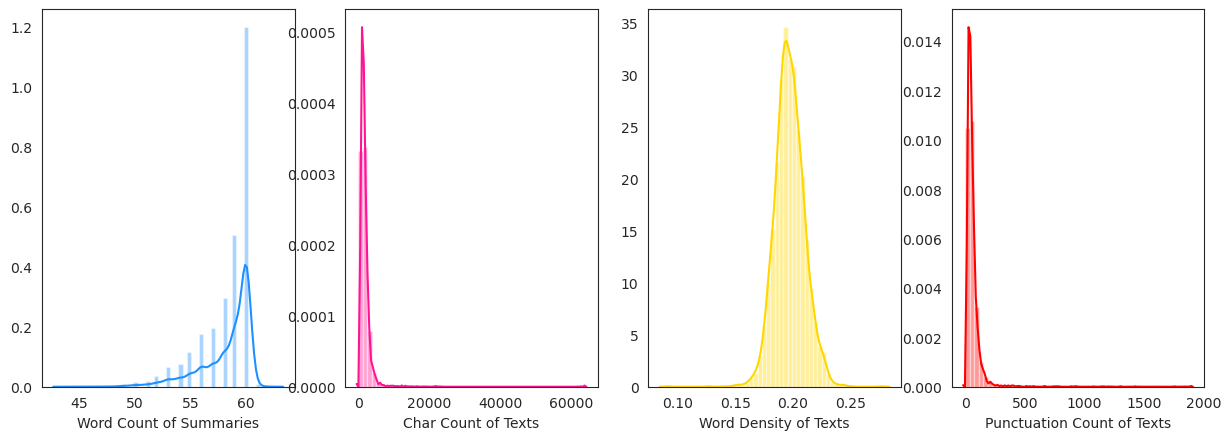

In [26]:
# Plot
kwargs = dict(hist_kws={'alpha':.7}, kde_kws={'linewidth':2})

# plot
fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharey=False, dpi=100)
sns.distplot(dataset['sum_word_count'] , color="dodgerblue", ax=axes[0], axlabel=labels_dict['sum_word_count'])
#axes[0].set_xlim(left=0, right=5000)
sns.distplot(dataset['text_char_count'] , color="deeppink", ax=axes[1], axlabel=labels_dict['text_char_count'])
#axes[1].set_xlim(left=0, right=5000)
sns.distplot(dataset['text_word_density'] , color="gold", ax=axes[2], axlabel=labels_dict['text_word_density'])
sns.distplot(dataset['text_punc_count'] , color="red", ax=axes[3], axlabel=labels_dict['text_punc_count'])
#axes[3].set_xlim(left=0, right=500)
#plt.xlim(50,75);
#plt.legend()

(4, 2)


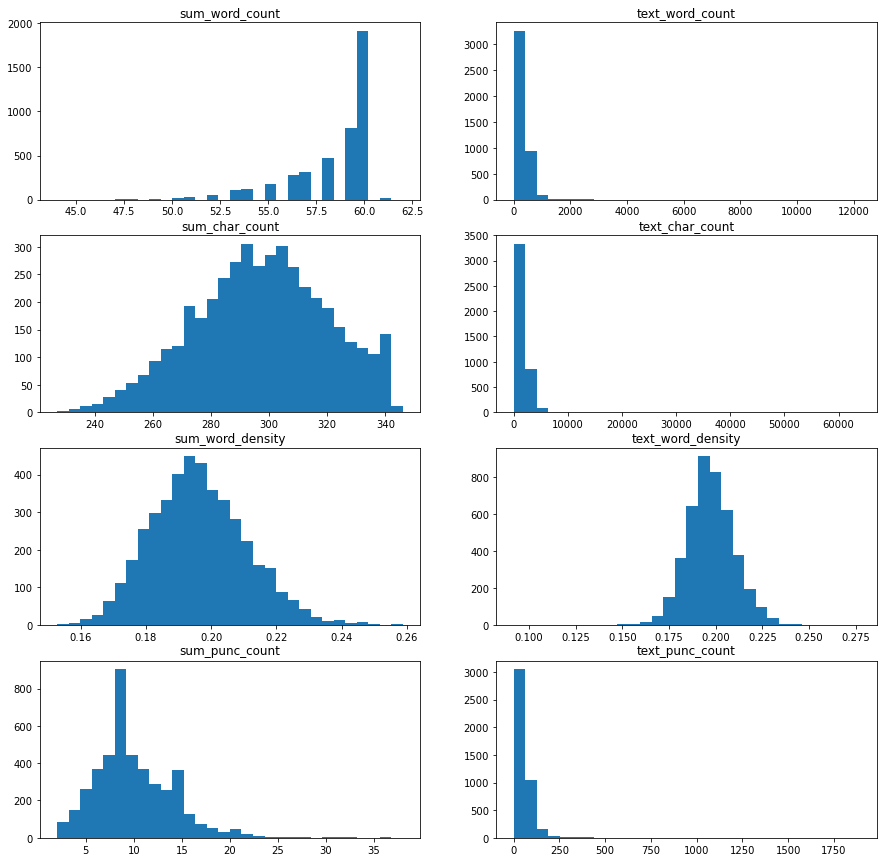

In [11]:
# Histograms for appicant featrures
data=dataset

plot_vars=np.array([['sum_word_count','text_word_count'],['sum_char_count','text_char_count'],
                    ['sum_word_density','text_word_density'],['sum_punc_count','text_punc_count']])
print(plot_vars.shape)

f, axes = plt.subplots(4, 2, sharey=False, figsize=(15,15))
#fig1, ax1 = plt.subplots()
for i in range(plot_vars.shape[0]):
    for j in range(plot_vars.shape[1]):
        if plot_vars[i,j]!=None:
            axes[i,j].set_title(plot_vars[i,j])
            axes[i,j].grid(False)
            axes[i,j].tick_params(
                axis='x',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom=True,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                labelbottom=True)
            axes[i,j].hist(data[plot_vars[i,j]],bins=30)
        else:
            axes[i,j].set_visible(False)

plt.show()

### Cleaning the data

Next, let’s perform a simple preprocessing on the content of the text column to make them more amenable for analysis, and reliable results. To do that, we’ll remove any punctuation, digit and then lowercase the text

In [66]:
def clean_text(text):
    ''' Apply some basic techniques for cleaning a text for an analysis of words
    
    Input:
       - text: text to be cleaned
    Output:
       - result: cleaned text
    '''
    # Lowercase the text
    text = text.lower()
    # Remove any  non-alphabet characters including digits
    pattern =  r'[^a-zA-Z\s]'    
    text = re.sub(pattern, '', text)
    # Remove punctuation
    #table=str.maketrans('','',string.punctuation)
    #text = text.translate(table)
    # Remove the stopwords    
    tokens = nltk.word_tokenize(text)    
    tokens = [token.strip() for token in tokens]    
    text = ' '.join([token for token in tokens if token not in stopword])
    return text

### Wordclouds for summary and text
A Wordcloud (or Tag cloud) is a visual representation of text data. It displays a list of words, the importance of each beeing shown with font size or color (the bigger the more frequent). This format is useful for quickly perceiving the most relevant terms on a document or set of documents.
We will draw the wordcloud for the source texts and the summaries to compare if they are very similar, it will allow us to check that the relevant concepts have been correctly extracted in the summaries.

Before building the wordclouds we need to do some basic cleaning in the dataset.

In [67]:
cleaned_summary = dataset['summary'].apply(lambda x : clean_text(x))
cleaned_text = dataset['text'].apply(lambda x : clean_text(x))

Build the wordcloud for source texts

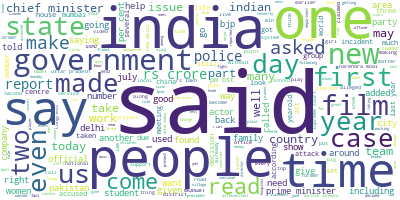

In [68]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(cleaned_text.values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

Now it is time to build the Cloud of Words for the summaries

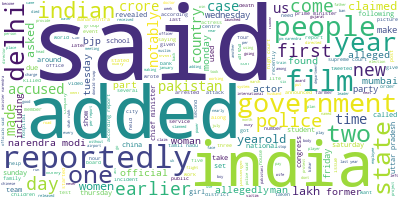

In [69]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(cleaned_summary.values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

#### Conslusion abut word clouds

### Topic Modelling

In this post, we will learn how to identity which topic is discussed in a document, called topic modelling. In particular, we will cover Latent Dirichlet Allocation (LDA): a widely used topic modelling technique. And we will apply LDA to convert set of research papers to a set of topics.
Research paper topic modelling is an unsupervised machine learning method that helps us discover hidden semantic structures in a paper, that allows us to learn topic representations of papers in a corpus. The model can be applied to any kinds of labels on documents, such as tags on posts on the website.

Link a revisar: 
https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
Con herramientas para visualizarlos

Otro link:
https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21
Visualizacion y detalle interesante

Next, let’s work to transform the textual data in a format that will serve as an input for training LDA model. We start by converting the documents into a simple vector representation (Bag of Words BOW). Next, we will convert a list of titles into lists of vectors, all with length equal to the vocabulary.

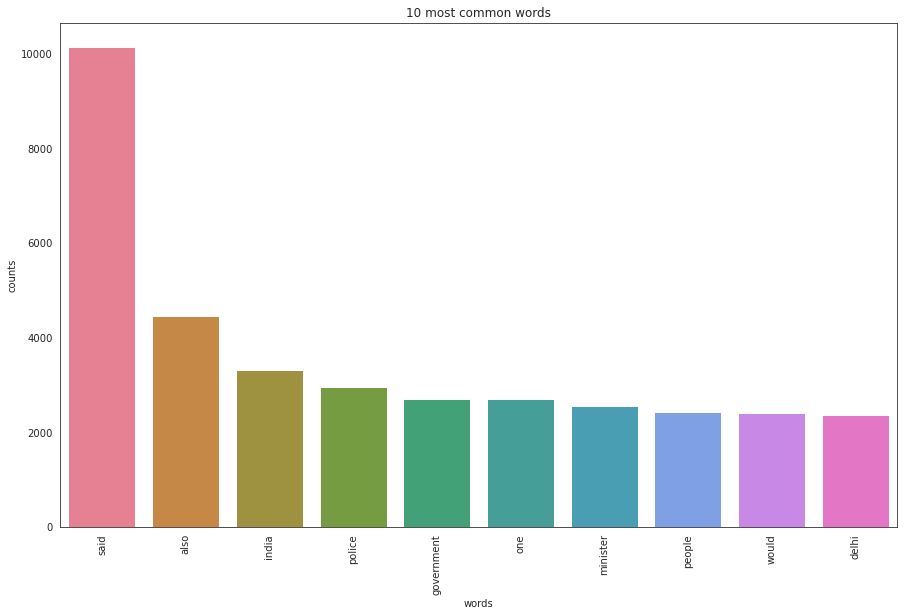

In [70]:
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
    
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer()
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(cleaned_text)
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

In [73]:
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    ''' Print the topics detected and the n_top_words that contains
    Input:
       - model: LDA model for the text
       - count_cectorizer: the count vectorizer object
       - n_top_words: the number of words to consider in a topic
    '''
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 5
number_words = 10
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
said minister party bjp chief government also people congress modi

Topic #1:
said also government india delhi new would state indian per

Topic #2:
said one also people new passengers india flight time company

Topic #3:
film india said first one pm actor also time like

Topic #4:
police said rs delhi court also case two crore one


In [79]:
from gensim import corpora
dictionary = corpora.Dictionary(cleaned_text)
corpus = [dictionary.doc2bow(text) for text in cleaned_text]

import pickle
pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

TypeError: doc2bow expects an array of unicode tokens on input, not a single string

In [ ]:
import gensim
NUM_TOPICS = 5
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
ldamodel.save('model5.gensim')
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

### Visualization the topic modelling results

Now that we have a trained model let’s visualize the topics for interpretability. To do so, we’ll use a popular visualization package, pyLDAvis which is designed to help interactively with:
- Better understanding and interpreting individual topics, and
- Better understanding the relationships between the topics.

In [91]:
LDAvis_data_filepath = os.path.join('./ldavis_prepared_'+str(number_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
#if 1 == 1:

LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)
with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath,'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(number_topics) +'.html')

#### Links:
https://www.kaggle.com/shivamb/seconds-from-disaster-text-eda-and-analysis

https://www.kaggle.com/caractacus/thematic-text-analysis-using-spacy-networkx